In [1]:
# Import
import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Parameters
n = 30
C = 10
meanT = [10, 15, 20, 25, 30, 35, 40]
meanM = 30
oneItemST = 3

# Factors
p = 0
K = 0

# CSV name
csv_name = "FirstCalibration"

In [3]:

CSV = pd.read_csv(f"{csv_name}.csv").fillna(0)

CSV = pd.concat([CSV[CSV["type"] == "scalar"], CSV[CSV["attrname"] == "iterationvarsd"]])

# CSV.to_csv(f"{csv_name}_cleaned.csv", index=False)

C:\Users\giova\AppData\Local\Temp\ipykernel_1440\131608406.py:1: DtypeWarning: Columns (6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  CSV = pd.read_csv(f"{csv_name}.csv").fillna(0)


In [4]:

# In the rows where attrname == "iterationvarsd", 
# attrvalue contains the current configuration
# in the following format: exponential(30s,_0)
configurationInfo = CSV[CSV["attrname"] == "iterationvarsd"]

CSV_Scalar = CSV[CSV["type"] == "scalar"]

# TW: Total Mean Waiting Time [GlobalSink]
Exp_TW = CSV_Scalar[CSV_Scalar["module"].str.contains("SuperMarket.globalSink")]
Exp_TW = Exp_TW[Exp_TW["name"] == "totalQueueingTime:mean"]


# Dictionary for containing all the DataFrames
CSV_Dict = {
    "TW": Exp_TW
}

# PI: Performance Indexes
PI = {}

# Configurations
config = {}

for _, row in configurationInfo.iterrows():
    # The key of config is the run number and the value is the value of T
    config[row["run"].split("-")[1]] = re.findall(r'\d+', row["attrvalue"])[0]


for key in CSV_Dict:
    
    # --- Initialization Phase ---
    # The key of PI is the Performance Index and the value is a dictionary
    PI[key] = {}

    for c in config:
        # config[c] is a value of T
        PI[key][config[c]] = {}

        for cc in config:
            # cc contains the run number
            PI[key][config[c]][cc] = {}
    # --- End of Initialization Phase ---

    for _, row in CSV_Dict[key].iterrows():
        # each row of CSV_Dict[key] is a run of the simulation with a specific value of T

        # In row we save the run number
        run = row["run"].split("-")[1]

        # Using a regex we search for all the occurencies of numbers inside row['module']
        q = re.findall(r'\d+', row["module"])

        if q:
            # If a number was found
            # e.g. SuperMarket.checkout.queues[0]
            # We take the first one (and only one)
            q = q[0]

            string = f"Q{q}"

            # For the current run we save the PI value of the queue "string" (e.g. Q0)
            PI[key][config[run]][run][string] = float(row["value"]) 
        else:
            # If none number was found
            # e.g. SuperMarket.globalSink

            # For the current run we save the PI value of the overall system
            PI[key][config[run]][run] = float(row["value"])

# PI_df: Performance Indexes DataFrame
PI_df = {}

# In Q we are going to save the names of the queues in the format Q0, Q1, ...
Q = []
for i in range(C):
    Q.append(f"Q{i}")


# --- Initialization Phase ---

for pi in PI:

    # The key of PI_df is the Performance Index and the value is a dictionary
    PI_df[pi] = {}

    for config in PI[pi]:

        if pi != "TW":
            # If pi is not TW we create a DataFrame with the columns Q (one column for each queue)
            PI_df[pi][config] = pd.DataFrame(columns=Q)

        else:
            # If pi is TW we create a DataFrame with just one column GS (Global Sink)
            PI_df[pi][config] = pd.DataFrame(columns=["GS"])

# --- End of Initialization Phase ---


for pi in PI:

    for config in PI[pi]:
    
        for run in PI[pi][config]:
            
            # Here we need to check if PI[pi][config][run] is different from {}
            # because if it is {} it means that the run was not related to 
            # that specific value of T
            if PI[pi][config][run]:

                # Check if PI[pi][config][run] is a dictionary
                if isinstance(PI[pi][config][run], dict):
                    # If it is a dictionary it means that
                    # it contains the PI values for each queue
                    for q in PI[pi][config][run]:
                        # We add the PI value of the queue q to the DataFrame
                        # at the row 'run' and at the column 'q'
                        PI_df[pi][config].loc[int(run), q] = PI[pi][config][run][q]
                else:
                    # If it is not a dictionary it means that
                    # it contains the PI value for the overall system

                    # We add the PI value of the overall system to the DataFrame
                    # at the row 'run'
                    PI_df[pi][config].loc[int(run)] = PI[pi][config][run]

        # We sort the DataFrame by the index (run number)
        PI_df[pi][config] = PI_df[pi][config].sort_index()
        # We reset the index of the DataFrame to start from 0
        PI_df[pi][config] = PI_df[pi][config].reset_index(drop=True)



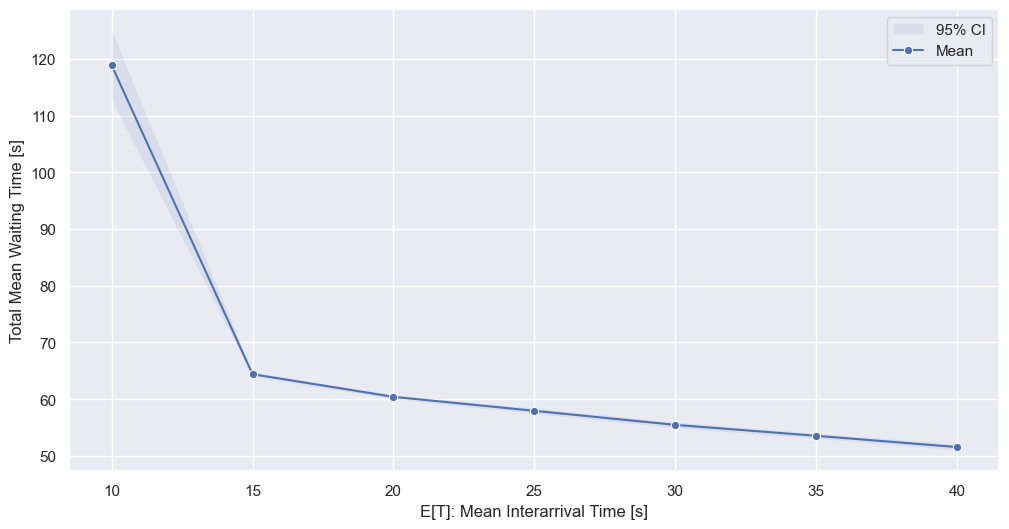

In [5]:
# First Calibration

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "TW"

y_V = []

# Confidence Interval Bounds
ci_lb = []
ci_ub = []

for t in meanT:
    
    # We save in y_V the mean value for the current t
    y_V.append(PI_df[pi][str(t)]["GS"].mean())

    # We compute the confidence interval bounds
    ci_lb.append(PI_df[pi][str(t)]["GS"].mean() - (1.96 * (PI_df[pi][str(t)]["GS"].std() / math.sqrt(n))))
    ci_ub.append(PI_df[pi][str(t)]["GS"].mean() + (1.96 * (PI_df[pi][str(t)]["GS"].std() / math.sqrt(n))))

# We plot the confidence intervals
plt.fill_between(meanT, ci_lb, ci_ub, alpha=0.1, label="95% CI")

# We plot the line for the current p_
sns.lineplot(x=meanT, y=y_V, marker='o', label="Mean")

# Set the x-axis limits
# plt.xlim(0, 45)  
# Set the y-axis limits
# plt.ylim(0, 150)  

# plt.title('First Calibration with 95% CI [Zoomed]')
plt.xlabel('E[T]: Mean Interarrival Time [s]')
plt.ylabel('Total Mean Waiting Time [s]')

plt.legend()
plt.show()